# AGN selections

Plots and stats for AGN section of the paper.

In [1]:
import pandas as pd
import numpy as np
import pickle as pcl

from scipy.stats import binned_statistic

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

from palettable.tableau import GreenOrange_12
cmap = GreenOrange_12.hex_colors

from astropy.cosmology import Planck13, z_at_value
import astropy.units as u

from methods import normalise_coods
from methods import z_distort
from methods import factor_h
from methods import bhattacharyya
from methods import get_protoclusters

from overdensity_cylinder import overdensity_cylinder

h = 0.673
L = 480.279 / h

c = 2.97e8 # m s^-1

directory = '/lustre/scratch/astro/cl478/protoclusters_data/'
# directory = '/cosma/home/dp004/dc-love2/gpfs/protoclusters_data/'

In [2]:
redshifts = ['2p07','3p10','3p95','5p03','5p92','6p97','8p22','8p93','9p72']
zees = [float(z.replace('p','.')) for z in redshifts]

Load data

In [3]:
gals_sfr = [None] * len(redshifts)
gals_mstar = [None] * len(redshifts)

for i, (z, zed) in enumerate(zip(redshifts,zees)):  
    gals_sfr[i] = z_distort(factor_h(pd.read_csv('%shenriques2015a_z%s_sfr_r200.csv'%(directory,z), \
                              skiprows=122, skipfooter=1, engine='python'), h), zed, L)
    
    gals_mstar[i] = z_distort(factor_h(pd.read_csv('%shenriques2015a_z%s_stellarMass_r200.csv'%(directory,z), \
                                skiprows=122, skipfooter=1, engine='python'), h), zed, L)
    
    for gals in [gals_sfr, gals_mstar]:
#         print "Filling in NaN values..."
        gals[i].ix[np.isnan(gals[i]['z0_haloId']), 'z0_haloId'] = -1
        gals[i].ix[np.isnan(gals[i]['z0_centralId']), 'z0_centralId'] = -1
        gals[i].ix[np.isnan(gals[i]['z0_central_mcrit200']), 'z0_central_mcrit200'] = 0

/mnt/pact/cl478/protoclusters/protoclusters/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


Quasar / HzRG accretion limits

In [4]:
def luminosity_to_accretion(lum, epsilon=0.1):    
    acc = lum / epsilon / c**2
    acc /= 1.989e30
    acc *= (365.25*24*60*60)
    acc /= 1e7
    return acc

quasar_lim = luminosity_to_accretion(2e43)
cons_quasar_lim = luminosity_to_accretion(1e44)

radio_lim = 0.001
cons_radio_lim = 0.004 # .005

print "quasar limits:", quasar_lim, cons_quasar_lim
print "radio limits:", radio_lim, cons_radio_lim

quasar limits: 0.00359737971146 0.0179868985573
radio limits: 0.001 0.004


In [5]:
def accr_to_lbol(accr, sol=True, epsilon=0.1):
    lbol = accr / (365.25*24*60*60) * c**2 * epsilon * 1.989e30 * 1e7
    if sol: lbol /= 3.9e33
    return lbol

### Number densities

In [6]:
def H06(x, z=0, hubble_units=0, **kwargs):
    """
    Inputs: xmin, xmax - range along x-axis
            z - redshift
            *args - optional plotting arguments
    """

    h100=0.7
    phi_star=10.**(-4.825) #/h100**3
    zref=2.
    log10L_star0=13.036  # L_star is in Lsun
    kL1=0.632
    kL2=-11.76
    kL3=-14.25
    gamma10=0.417
    kg1=-0.623
    gamma20=2.174
    kg21=1.460
    kg22=-0.793
    
    eps=np.log10((1+z)/(1+zref))
    x_star=log10L_star0+kL1*eps+kL2*eps**2+kL3*eps**3
    if hubble_units==2: x_star=x_star+2*np.log10(h100)
    xx=10.**(x-x_star)
    gamma1=gamma10*10.**(eps*kg1)
    gamma2=2.*gamma20/(10.**(eps*kg21)+10.**(eps*kg22))
    y=phi_star/(xx**gamma1+xx**gamma2)
    if hubble_units==1 or hubble_units==2: y=y/h100**3
    return y


In [7]:
def Wall(z):
    return -12.49 + 2.704*z - 1.145*z**2 + 0.1796*z**3 - 0.01019*z**4


In [8]:
from scipy.integrate import quad

In [9]:
numbden = np.zeros((2, len(redshifts[:5])))

for i, z in enumerate(redshifts[:5]):
    numbden[0, i] = np.sum(gals[i]['zn_radioAccretionRate'] >= radio_lim) / L**3  # Mpc^-3
    numbden[1, i] = np.sum(gals[i]['zn_quasarAccretionRate'] >= quasar_lim) / L**3  # Mpc^-3

/mnt/pact/cl478/protoclusters/protoclusters/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in double_scalars
/mnt/pact/cl478/protoclusters/protoclusters/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in double_scalars


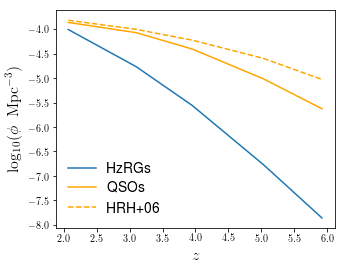

In [10]:
fig = plt.figure(figsize=(5, 4))

plt.plot(zees[:5], np.log10(numbden[0]), label='HzRGs');
plt.plot(zees[:5], np.log10(numbden[1]), label='QSOs', color='orange');

# use cut off equivalent to 1e44 Lbol erg s^-1
plt.plot(zees[:5], np.log10([quad(H06, np.log10(1e11 / 3), np.inf, z)[0] for z in zees[:5]]), label='HRH+06', color='orange', linestyle='dashed')

plt.legend(frameon=False, prop={'size': 14});
plt.xlabel('$z$', size=16)
plt.ylabel('$\mathrm{log_{10}(\phi \;\; Mpc^{-3})}$', size=16)

# plt.savefig('output/AGN_number_densities.png', bbox_inches='tight', dpi=300)

## Average host halo mass

must adjust cuts to include lower accretion rate AGN

In [11]:
print radio_lim, np.log10(accr_to_lbol(radio_lim, sol=False))
print quasar_lim, np.log10(accr_to_lbol(quasar_lim, sol=False))

0.001 42.7450437147
0.00359737971146 43.3010299957


In [12]:
radio_lim_all = 1.8e-4
quasar_lim_all = 1.8e-4

print radio_lim_all, np.log10(accr_to_lbol(radio_lim_all, sol=False))
print quasar_lim_all, np.log10(accr_to_lbol(quasar_lim_all, sol=False))

0.00018 42.0003162198
0.00018 42.0003162198


In [13]:
from scipy.stats import binned_statistic
from matplotlib.colors import LogNorm

my_cmap = plt.cm.viridis
my_cmap.set_under('w',1)

2.07
3.1
3.95
5.03


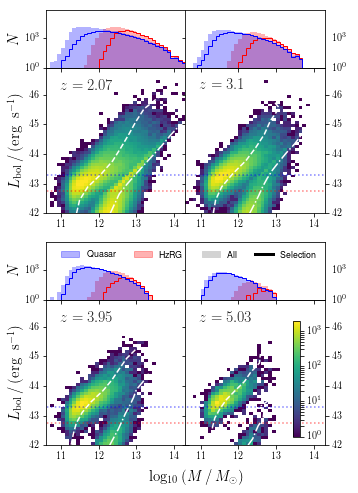

In [16]:
fig = plt.figure(figsize=(5, 8))

gs1 = gridspec.GridSpec(15, 2)
gs1.update(hspace=0, wspace=0) # bottom = 0.57, top = 1,

ax1 = fig.add_subplot(gs1[2:7,0])
ax2 = fig.add_subplot(gs1[2:7,1])
ax3 = fig.add_subplot(gs1[10:15,0])
ax4 = fig.add_subplot(gs1[10:15,1])

ax1t = fig.add_subplot(gs1[0:2,0])
ax2t = fig.add_subplot(gs1[0:2,1])
ax3t = fig.add_subplot(gs1[8:10,0])
ax4t = fig.add_subplot(gs1[8:10,1])

axes = [ax1,ax2,ax3,ax4]
axest = [ax1t,ax2t,ax3t,ax4t]

xbins = np.linspace(10,15,51)
ybins = np.linspace(42,47,51)

for i, (ax, axt, z) in enumerate(zip(axes, axest, zees)):
    
    print z
    
    ax.text(0.1, 0.85, '$z = %s$'%z, transform = ax.transAxes, size=15, alpha=0.8)

    
    # histograms
    axt.hist(np.log10(gals[i]['zn_mvir'][gals[i]['zn_radioAccretionRate'] >= radio_lim_all] * 1e10), 
             alpha=.3, label='HzRG', color='red', bins=xbins)
    
    axt.hist(np.log10(gals[i]['zn_mvir'][gals[i]['zn_quasarAccretionRate'] >= quasar_lim_all] * 1e10), 
             alpha=.3, label='Quasar', color='blue', bins=xbins)
    
    axt.hist(np.log10(gals[i]['zn_mvir'][gals[i]['zn_radioAccretionRate'] >= radio_lim] * 1e10), 
             histtype='step', color='red', bins=xbins)
    
    axt.hist(np.log10(gals[i]['zn_mvir'][gals[i]['zn_quasarAccretionRate'] >= quasar_lim] * 1e10), 
             histtype='step', color='blue', bins=xbins)

    axt.set_yscale("log")
    
    # medians
    quasar_stat = binned_statistic(np.log10(accr_to_lbol(gals[i]['zn_quasarAccretionRate'][gals[i]['zn_quasarAccretionRate'] > quasar_lim_all], sol=False)),
                                  np.log10(gals[i]['zn_mvir'][gals[i]['zn_quasarAccretionRate'] > quasar_lim_all] * 1e10), statistic='median')

    ax.plot(quasar_stat[0], quasar_stat[1][1:] - (quasar_stat[1][1] - quasar_stat[1][0]), 
            linestyle='dashed', color='white')


    radio_stat = binned_statistic(np.log10(accr_to_lbol(gals[i]['zn_radioAccretionRate'][gals[i]['zn_radioAccretionRate'] > radio_lim_all], sol=False)),
                                 np.log10(gals[i]['zn_mvir'][gals[i]['zn_radioAccretionRate'] > radio_lim_all] * 1e10), statistic='median')

    ax.plot(radio_stat[0], radio_stat[1][1:] - (radio_stat[1][1] - radio_stat[1][0]), 
            linestyle='-.', color='white')

    # 2d hist
#     temp_gals = np.array(gals[i][['zn_mvir','zn_quasarAccretionRate']][gals[i]['zn_quasarAccretionRate'] > quasar_lim])
#     temp_gals = np.vstack([temp_gals, gals[i][['zn_mvir','zn_radioAccretionRate']][gals[i]['zn_radioAccretionRate'] > radio_lim]])

    # combined accretion rate, for all galaxies above either accretion cut
    temp_gals = gals[i][['zn_mvir','zn_quasarAccretionRate',
         'zn_radioAccretionRate']][(gals[i]['zn_radioAccretionRate'] > radio_lim_all) \
          | (gals[i]['zn_quasarAccretionRate'] > quasar_lim_all)]

    temp_gals['accr'] = temp_gals['zn_quasarAccretionRate'] + temp_gals['zn_radioAccretionRate']

    
    
    if i == 0:
        p = ax.hist2d(np.log10(temp_gals['zn_mvir'] * 1e10), np.log10(accr_to_lbol(temp_gals['accr'], sol=False)),
                   bins=[xbins,ybins], cmap=my_cmap, vmin=1,  norm=LogNorm());
    else:
        ax.hist2d(np.log10(temp_gals['zn_mvir'] * 1e10), np.log10(accr_to_lbol(temp_gals['accr'], sol=False)),
               bins=[xbins,ybins], cmap=my_cmap, vmin=1,  norm=LogNorm());
    

    ax.set_ylim(42, 46.9);
    ax.set_xlim(10.6, 14.3);
    axt.set_xlim(10.6, 14.3);
    
    axt.set_xticklabels([])
    
    ax.yaxis.set_ticks_position('both')
    
    ax.tick_params('both', which='both')
    axt.set_ylim(1, 5e5)
    
    ax.hlines(np.log10(accr_to_lbol(radio_lim, sol=False)), 10, 15, color='red', linestyle='dotted', alpha=.5)
    ax.hlines(np.log10(accr_to_lbol(quasar_lim, sol=False)), 10, 15, color='blue', linestyle='dotted', alpha=.5)
    
    
# for ax in [ax1,ax2]:
#     ax.tick_params(labeltop=True, top=True, labelbottom=False)
    
for ax in [ax2,ax4,ax2t,ax4t]:
    ax.tick_params(labelright=True, labelleft=False)
    

fig.text(0.41, 0.06, '$\mathrm{log_{10}} \, (M \,/\, M_{\odot})$', transform=fig.transFigure, size=15)

for ax, axt in zip([ax1,ax3], [ax1t,ax3t]):
    ax.set_ylabel('$L_{\mathrm{bol}} \,/\, (\mathrm{erg \;\; s^{-1}})$', size=15)
    axt.set_ylabel('$N$', size=15)
    
    
## Legend

# Legend 2
patchA = mpatches.Patch(color='red',alpha=.3,label='HzRG')
patchB = mpatches.Patch(color='blue',alpha=.3,label='Quasar')

patch1 = mpatches.Patch(color='lightgrey',label='All')
line1 = plt.Line2D((0,1.5),(0,0), color='black', linestyle='solid', linewidth=3, label='Selection')

legend = ax4t.legend(handles = [patchB, patchA, patch1, line1], ncol=4, prop={'size': 9}, 
                     labelspacing=.2, frameon=False, bbox_to_anchor=(1., 0.99)).set_zorder(10)


# colorbar
cax = fig.add_axes([0.81, 0.14, 0.02, 0.2])
fig.colorbar(p[3], cax, orientation = 'vertical') 

# plt.savefig('output/AGN_luminosities.png', bbox_inches='tight', dpi=300)

### Quasar / HzRG distance from protocluster centre

In [336]:
gals = gals_sfr

for i, redshift in enumerate(redshifts[:5]):
    
    agn = gals[i][gals[i]['zn_radioAccretionRate'] >= radio_lim].reset_index(drop=True) # find all agn    
    agn = agn[agn['z0_central_mcrit200'] >= 1e4].reset_index(drop=True) # agn in protoclusters
    
    distances = [None] * len(agn)

    for idx, q in agn.iterrows():
        
        # subset coordinates of descendant halo
        subset_gals = gals[i][gals[i]['z0_centralId'] == q['z0_centralId']]
        
        coods = normalise_coods(np.array(subset_gals[['zn_x','zn_y','zn_z']]), L)  # normalise coordinates
        center = np.median(coods,axis=0) # find descendant halo center
        quasar_location = coods[subset_gals['zn_galaxyId'] == q['zn_galaxyId']]
        
        # distance between agn and descendant halo progenitor centre
        distances[idx] = float(np.sqrt(np.sum((quasar_location - center)**2, axis=1)))  
    
    
    print "z:", redshift, "n(radio):", len(agn), "\nmean:", round(np.mean(distances),2),\
    "median:", round(np.median(distances),2), "std:", round(np.std(distances),2),"\n"
    

z: 2p07 n(radio): 11541 
mean: 4.32 median: 3.77 std: 2.75 

z: 3p10 n(radio): 3421 
mean: 4.47 median: 3.78 std: 3.02 

z: 3p95 n(radio): 690 
mean: 4.29 median: 3.54 std: 2.92 

z: 5p03 n(radio): 53 
mean: 4.44 median: 3.43 std: 3.5 

z: 5p92 n(radio): 5 
mean: 6.01 median: 5.44 std: 3.26 



In [337]:
gals = gals_sfr

for i, redshift in enumerate(redshifts[:5]):
    
    agn = gals[i][gals[i]['zn_quasarAccretionRate'] >= radio_lim].reset_index(drop=True) # find all agn    
    agn = agn[agn['z0_central_mcrit200'] >= 1e4].reset_index(drop=True) # agn in protoclusters
    
    distances = [None] * len(agn)

    for idx, q in agn.iterrows():
        
        # subset coordinates of descendant halo
        subset_gals = gals[i][gals[i]['z0_centralId'] == q['z0_centralId']]
        
        coods = normalise_coods(np.array(subset_gals[['zn_x','zn_y','zn_z']]), L)  # normalise coordinates
        center = np.median(coods,axis=0) # find descendant halo center
        quasar_location = coods[subset_gals['zn_galaxyId'] == q['zn_galaxyId']]
        
        # distance between agn and descendant halo progenitor centre
        distances[idx] = float(np.sqrt(np.sum((quasar_location - center)**2, axis=1)))  
    
    
    print "z:", redshift, "n(quasar):", len(agn), "\nmean:", round(np.mean(distances),2),\
    "median:", round(np.median(distances),2), "std:", round(np.std(distances),2),"\n"
    

z: 2p07 n(quasar): 20287 
mean: 5.27 median: 4.74 std: 3.07 

z: 3p10 n(quasar): 14324 
mean: 5.57 median: 5.01 std: 3.23 

z: 3p95 n(quasar): 7183 
mean: 5.68 median: 5.05 std: 3.37 

z: 5p03 n(quasar): 2033 
mean: 5.74 median: 5.1 std: 3.55 

z: 5p92 n(quasar): 561 
mean: 5.79 median: 4.99 std: 3.66 



#### Find average galaxy distance from protocluster centre

In [464]:
gals = gals_sfr

distances = [None] * len(redshifts)
centres = [None] * len(redshifts)

for i, redshift in enumerate(redshifts[:1]):
    
#     clusters = pd.unique(gals[i][gals[i]['z0_central_mcrit200'] > 1e4]['z0_centralId'])
    clusters = get_protoclusters(gals[i], L)
    
#     clusters['coods'] = normalise_coods(np.array(clusters['coods'][[0,1,2]]), L)
    
    distances[i] = [None] * len(clusters['coods'])
    centres[i] = [None] * len(clusters['coods'])

    for idx, (clust, c) in enumerate(zip(clusters['clusters'].iterrows(), clusters['coods'].iterrows())):

        subset_gals = gals[i][gals[i]['z0_centralId'] == clust[1]['z0_centralId']]  # subset coordinates of descendant halo
        coods = normalise_coods(np.array(subset_gals[['zn_x','zn_y','zn_z']]), L)  # normalise coordinates

#         center = np.median(coods,axis=0) # find descendant halo center
        
#         centres[i][idx] = center
        distances[i][idx] = np.mean(np.sqrt(np.sum(pow(coods - c[1], 2.),axis=1)))


In [467]:
[np.mean(d) for d in distances[0]]

[6.3979959204178165,
 5.671302734348739,
 5.7987168524054988,
 5.8568401225655249,
 4.2824340181707958,
 5.1115493797539591,
 5.0929915122393883,
 5.5022002554511387,
 3.760981044497242,
 3.7311565839861909,
 4.6868327720994953,
 5.0137068258584963,
 4.1199655579520451,
 6.590794400745386,
 3.4489412427779578,
 8.3639368618973204,
 4.6631229389632631,
 5.593665970877554,
 4.6467738487316819,
 4.2214576523070741,
 3.7636408271532851,
 5.2826626523797051,
 4.7752961173288444,
 4.0218730557326676,
 4.3402064455976701,
 4.5427626627037281,
 4.9166943252895425,
 4.0756886350514563,
 5.1481349015453537,
 4.6619909136995235,
 4.1616751380670172,
 4.5554163468804951,
 3.4151846880215864,
 4.4722651125323729,
 3.2284958772567207,
 4.1071577086148032,
 4.3841144308795679,
 7.5190969991950229,
 4.1792032564545796,
 4.4806255175670167,
 4.6248051231957623,
 4.5502593592726734,
 7.5547937690889935,
 5.1880580622770118,
 4.9264491080596153,
 5.2672310385189247,
 4.6180185830927716,
 4.76117245878508

In [427]:
np.median([np.mean(d) for d in distances[0]])

4.6087324516083266

!!!!

Need to calculate overdensity surrounding quasars in the model...

In [504]:
R = [3, 6, 8, 10, 14, 20]

quasar_stats = {z: {'cstats': {r: None for r in R}, 'clusters': None} for z in zees[:5]}
hzrg_stats = {z: {'cstats': {r: None for r in R}, 'clusters': None} for z in zees[:5]}

In [505]:
for i, z in enumerate(zees[:5]):
    
    print z
    
    # find all agn
    hzrgs = gals[i][gals[i]['zn_radioAccretionRate'] >= radio_lim].reset_index(drop=True) 
    quasars = gals[i][gals[i]['zn_quasarAccretionRate'] >= quasar_lim].reset_index(drop=True) 
    
    # save cluster mass data
    hzrg_stats[z]['clusters'] = hzrgs['z0_central_mcrit200']
    quasar_stats[z]['clusters'] = quasars['z0_central_mcrit200']
    
    for r in R:  # loop through aperture sizes
        print r
    
        quasar_stats[z]['cstats'][r] = overdensity_cylinder(gals_mstar[i], quasars[['zn_x','zn_y','zn_z']],
                                                            L=L, R=r, dc=r)
        
        hzrg_stats[z]['cstats'][r] = overdensity_cylinder(gals_mstar[i], hzrgs[['zn_x','zn_y','zn_z']],
                                                          L=L, R=r, dc=r)

    
pcl.dump([quasar_stats, hzrg_stats], open('agn_stats.p', 'w'))
# quasar_stats, hzrg_stats = pcl.load(open('agn_stats.p', 'r'))

2.07
3
6
8
10
14
20
3.1
3
6
8
10
14
20
3.95
3
6
8
10
14
20
5.03
3
6
8
10
14
20
5.92
3
6
8
10
14
20


Quasar overdensity / descendant mass plot, figure 9

In [507]:
BinLimits = [np.linspace(-1, 39, 21), 
             np.linspace(-1, 17, 37),
             np.linspace(-1, 11, 25)]

Bins = [np.linspace(0, 38, 20),
        np.linspace(-0.75, 16.75, 36), 
        np.linspace(-0.75, 10.75, 24)]

print BinLimits[1]
print Bins[1]

[ -1.   -0.5   0.    0.5   1.    1.5   2.    2.5   3.    3.5   4.    4.5
   5.    5.5   6.    6.5   7.    7.5   8.    8.5   9.    9.5  10.   10.5
  11.   11.5  12.   12.5  13.   13.5  14.   14.5  15.   15.5  16.   16.5
  17. ]
[ -0.75  -0.25   0.25   0.75   1.25   1.75   2.25   2.75   3.25   3.75
   4.25   4.75   5.25   5.75   6.25   6.75   7.25   7.75   8.25   8.75
   9.25   9.75  10.25  10.75  11.25  11.75  12.25  12.75  13.25  13.75
  14.25  14.75  15.25  15.75  16.25  16.75]


In [508]:
def func(x, a, b, c, d, C):
    return a * (x[1]+1)**b * (x[0]+1)**c + C


def scale(x):
    return np.log10(x * 1e3 * 1e10)


args=[1.45145241, -1.104172, 2.64782728, 1., 18.53122657]

scale(func(np.vstack([Bins[0], [2.07] * len(Bins[0])]), args[0], args[1], args[2], args[3],args[4]))

array([ 14.27765216,  14.41904247,  14.68450769,  14.96018932,
        15.20405544,  15.41356672,  15.59442327,  15.75247346,
        15.89237027,  16.01763427,  16.13092118,  16.23425669,
        16.3292096 ,  16.41701413,  16.49865598,  16.5749334 ,
        16.64650099,  16.71390173,  16.7775907 ,  16.83795288])

0 2.07
1 3.1
2 3.95
3 5.03


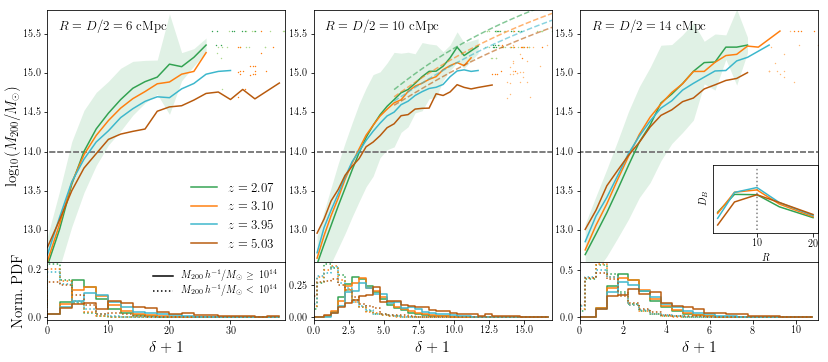

In [510]:
fig = plt.figure(figsize=(15,10))

gs1 = gridspec.GridSpec(32, 26)

gs1.update(bottom = 0.57, top = 1, hspace=0, wspace=5.5)

ax1 = fig.add_subplot(gs1[0:26,0:8])
ax5 = fig.add_subplot(gs1[26:32,0:8])
ax2 = fig.add_subplot(gs1[0:26,8:16])
ax6 = fig.add_subplot(gs1[26:32,8:16])
ax3 = fig.add_subplot(gs1[0:26,16:24])
ax7 = fig.add_subplot(gs1[26:32,16:24])
ax9 = fig.add_subplot(gs1[16:23,20:24])

Bhatta =[[] for i in range(len(zees[:4]))]

radii = [6,10,14]

for i, z in enumerate(zees[:4]):
    print i, z
    
    for axt, axb, R, binLimits, bins in zip([ax1,ax2,ax3], [ax5,ax6,ax7], radii, BinLimits, Bins):
        
        cluster_mask = quasar_stats[z]['clusters'] >= 1e4
        nan_mask = ~np.isinf(1 / quasar_stats[z]['clusters'])
        
        # Subplot
        phiB, mass = np.histogram(quasar_stats[z]['cstats'][R][~cluster_mask,0] + 1, bins=binLimits, normed=True)
        phiA, mass = np.histogram(quasar_stats[z]['cstats'][R][cluster_mask,0] + 1, bins=binLimits, normed=True)
        
        DB, BC = bhattacharyya(phiA*np.diff(binLimits), phiB*np.diff(binLimits))
        
        Bhatta[i].append(DB)

        # Main Plot
        median = binned_statistic(quasar_stats[z]['cstats'][R][nan_mask,0] + 1, 
                          np.log10(quasar_stats[z]['clusters'][nan_mask] * 1e10),
                          bins=binLimits, statistic='median')[0]

        count = binned_statistic(quasar_stats[z]['cstats'][R][nan_mask,0] + 1, 
                                 np.log10(quasar_stats[z]['clusters'][nan_mask] * 1e10),
                                 bins=binLimits, statistic='count')[0]

        std = binned_statistic(quasar_stats[z]['cstats'][R][nan_mask,0] + 1, 
                               np.log10(quasar_stats[z]['clusters'][nan_mask] * 1e10),
                               bins=binLimits, statistic='std')[0]

        cmask = (count > 10)
        
        if i==0:
            axt.fill_between(bins[cmask], median[cmask]+std[cmask], median[cmask]-std[cmask], alpha=0.15, linewidth=0, color=cmap[i*2])

        axt.plot(bins[cmask], median[cmask], color=cmap[i*2], label='$z = %.2f$'%z)
        
        dgal_mask = quasar_stats[z]['cstats'][R][:,0] > max(bins[cmask])
        
        axt.scatter(quasar_stats[z]['cstats'][R][nan_mask & dgal_mask,0] + 1,
            np.log10(quasar_stats[z]['clusters'][nan_mask & dgal_mask] * 1e10),
            marker='.', s=8, c=cmap[i], lw=0, label=None)

        axb.set_xlim(0, binLimits[-1])
        axt.set_xlim(0, binLimits[-1])

        axt.hlines(14, -10, 60, linestyle='--', color='grey')
        
        axt.set_xticklabels([])
        
        # plot fitted mass
        if R == 10:
            axt.plot(bins[bins>4.5] + 1, scale(func(np.vstack([bins[bins>4.5], [z] * len(bins[bins>4.5])]), 
                     args[0],args[1],args[2],args[3],args[4])), color=cmap[i*2], 
                     linestyle='dashed', alpha=0.6)

        axb.step(bins, phiA, color=cmap[i*2], alpha=1)# + i*0.1)
        axb.step(bins, phiB, color=cmap[i*2], linestyle='dotted', alpha=1)# + i*0.1)

        if(i==0):
            axt.text(0.05, 0.92, '$R = D/2 = %s \; \mathrm{cMpc}$'%R, transform=axt.transAxes, size=13)


# Calculate R = 20 & 3 Bhattacharya distance, but don't plot
for i, z in enumerate(zees[:4]):
    
    for R, switch, binLimits, bins in zip([3,20],[True,False], BinLimits, Bins):
        
        cluster_mask = quasar_stats[z]['clusters'] >= 1e4
        
        # Subplot
        phiB, mass = np.histogram(quasar_stats[z]['cstats'][R][~cluster_mask,0] + 1, bins=binLimits, normed=True)
        phiA, mass = np.histogram(quasar_stats[z]['cstats'][R][cluster_mask,0] + 1, bins=binLimits, normed=True)
        
        DB, BC = bhattacharyya(phiA*np.diff(binLimits), phiB*np.diff(binLimits))
        
        if switch:
            Bhatta[i] = [DB] + Bhatta[i]
        else:
            Bhatta[i].append(DB)
        

for i,z in enumerate(zees[:4]):
    ax9.plot([3] + radii + [20], Bhatta[i], color=cmap[i*2])
    
    
ax9.set_xlabel('$R$')
ax9.set_ylabel('$D_{B}$')
ax9.set_yticks([])

# ax9.set_xticklabels([4,6,8,10,12,14,16,18,''])
ax9.set_yticklabels(['',0.2,0.3,0.4,0.5,0.6,0.7,''])

ax9.vlines(10, 0, 0.7, colors='grey', linestyles='dotted')

for ax in [ax1, ax2, ax3]:
    ax.set_ylim(12.6,15.8)
    

## Legend
line1 = plt.Line2D((0,1),(0,0), color='black', linestyle='solid')
line2 = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted')

ax5.legend(handles=[line1, line2], 
           labels=[r'$M_{200} \, h^{-1} / M_{\odot} \, \geq \, 10^{14}$',
                   r'$M_{200} \, h^{-1} / M_{\odot} \, < \, 10^{14}$'], 
           loc=1, prop={'size':10}, frameon=False)

ax1.legend(loc=4, frameon=False, prop={'size':13})

# for ax in [ax2,ax3,ax6,ax7]:
#     ax.set_yticklabels([])

    
for ax in [ax5,ax6,ax7]:
    ax.set_xlabel('$\delta + 1$', size=16, ha='center')
#     ax.set_ylim(0,0.5)

ax1.set_ylabel('$\mathrm{log_{10}}(M_{200} / M_{\odot})$',va='center',size=15,rotation='vertical',labelpad=8)
ax5.set_ylabel('$\mathrm{Norm. \; PDF}$',va='center',size=15,rotation='vertical',labelpad=8)  

# plt.savefig('output/quasar_select.png', bbox_inches='tight', dpi=300)

HzRG overdensity / descendant mass plot, figure 10

In [511]:
BinLimits = [np.linspace(-1, 38, 14), 
             np.linspace(-1, 17, 19),
             np.linspace(-1, 11, 13)]

Bins = [np.linspace(0.5, 36.5, 13),
        np.linspace(-0.5, 16.5, 18), 
        np.linspace(-0.5, 10.5, 12)]

print BinLimits[2]
print Bins[2]

[ -1.   0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.]
[ -0.5   0.5   1.5   2.5   3.5   4.5   5.5   6.5   7.5   8.5   9.5  10.5]


0 2.07
1 3.1
2 3.95
3 5.03


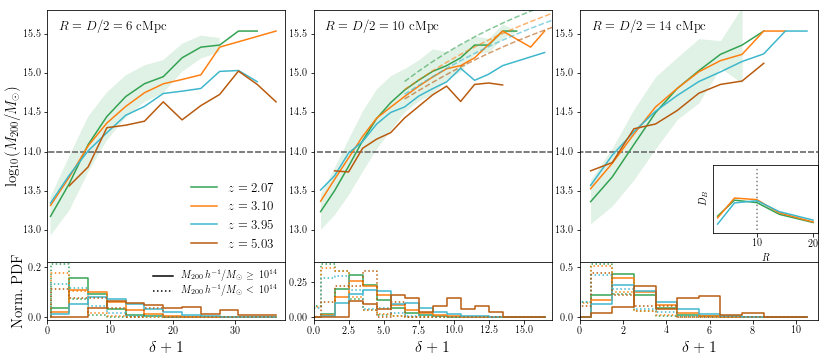

In [513]:
fig = plt.figure(figsize=(15,10))

gs1 = gridspec.GridSpec(32, 26)

gs1.update(bottom = 0.57, top = 1, hspace=0, wspace=5.5)

ax1 = fig.add_subplot(gs1[0:26,0:8])
ax5 = fig.add_subplot(gs1[26:32,0:8])
ax2 = fig.add_subplot(gs1[0:26,8:16])
ax6 = fig.add_subplot(gs1[26:32,8:16])
ax3 = fig.add_subplot(gs1[0:26,16:24])
ax7 = fig.add_subplot(gs1[26:32,16:24])
ax9 = fig.add_subplot(gs1[16:23,20:24])

Bhatta =[[] for i in range(len(zees[:4]))]

radii = [6,10,14]

for i, z in enumerate(zees[:4]):
    print i, z
    
    for axt, axb, R, binLimits, bins in zip([ax1,ax2,ax3], [ax5,ax6,ax7], radii, BinLimits, Bins):
        
        cluster_mask = hzrg_stats[z]['clusters'] >= 1e4
        nan_mask = ~np.isinf(1 / hzrg_stats[z]['clusters'])
        
        # Subplot
        phiB, mass = np.histogram(hzrg_stats[z]['cstats'][R][~cluster_mask,0] + 1, bins=binLimits, normed=True)
        phiA, mass = np.histogram(hzrg_stats[z]['cstats'][R][cluster_mask,0] + 1, bins=binLimits, normed=True)
        
        DB, BC = bhattacharyya(phiA*np.diff(binLimits), phiB*np.diff(binLimits))
        
        Bhatta[i].append(DB)

        # Main Plot
        median = binned_statistic(hzrg_stats[z]['cstats'][R][nan_mask,0] + 1, 
                          np.log10(hzrg_stats[z]['clusters'][nan_mask] * 1e10),
                          bins=binLimits, statistic='median')[0]

        count = binned_statistic(hzrg_stats[z]['cstats'][R][nan_mask,0] + 1, 
                                 np.log10(hzrg_stats[z]['clusters'][nan_mask] * 1e10),
                                 bins=binLimits, statistic='count')[0]

        std = binned_statistic(hzrg_stats[z]['cstats'][R][nan_mask,0] + 1, 
                               np.log10(hzrg_stats[z]['clusters'][nan_mask] * 1e10),
                               bins=binLimits, statistic='std')[0]

        cmask = (count > 0)
        
        if np.sum(cmask) == 0:
            print 'not enough radio galaxies...'
        else:
        
            if i==0:
                axt.fill_between(bins[cmask], median[cmask]+std[cmask], median[cmask]-std[cmask], 
                                 alpha=0.15, linewidth=0, color=cmap[i*2])

            axt.plot(bins[cmask], median[cmask], color=cmap[i*2], label='$z = %.2f$'%z)

            dgal_mask = hzrg_stats[z]['cstats'][R][:,0] > max(bins[cmask])

            axt.scatter(hzrg_stats[z]['cstats'][R][nan_mask & dgal_mask,0] + 1,
                np.log10(hzrg_stats[z]['clusters'][nan_mask & dgal_mask] * 1e10),
                marker='.', s=8, c=cmap[i], lw=0, label=None)

            
        # plot fitted mass
        if R == 10:
            axt.plot(bins[bins>4.5] + 1, scale(func(np.vstack([bins[bins>4.5], [z] * len(bins[bins>4.5])]), 
                     args[0],args[1],args[2],args[3],args[4])), color=cmap[i*2], 
                     linestyle='dashed', alpha=0.6)

        
        axb.set_xlim(0, binLimits[-1])
        axt.set_xlim(0, binLimits[-1])

        axt.hlines(14, -10, 60, linestyle='--', color='grey')

        axt.set_xticklabels([])

        axb.step(bins, phiA, color=cmap[i*2], alpha=1)# + i*0.1)
        axb.step(bins, phiB, color=cmap[i*2], linestyle='dotted', alpha=1)# + i*0.1)

        if(i==0):
            axt.text(0.05, 0.92, '$R = D/2 = %s \; \mathrm{cMpc}$'%R, transform=axt.transAxes, size=13)


# Calculate R = 20 & 3 Bhattacharya distance, but don't plot
for i, z in enumerate(zees[:4]):
    
    for R, switch, binLimits, bins in zip([3,20],[True,False], BinLimits, Bins):
        
        cluster_mask = hzrg_stats[z]['clusters'] >= 1e4
        
        phiB, mass = np.histogram(hzrg_stats[z]['cstats'][R][~cluster_mask,0] + 1, bins=binLimits, normed=True)
        phiA, mass = np.histogram(hzrg_stats[z]['cstats'][R][cluster_mask,0] + 1, bins=binLimits, normed=True)
        
        DB, BC = bhattacharyya(phiA*np.diff(binLimits), phiB*np.diff(binLimits))
        
        if switch:
            Bhatta[i] = [DB] + Bhatta[i]
        else:
            Bhatta[i].append(DB)
        

for i,z in enumerate(zees[:3]):
    ax9.plot([3] + radii + [20], Bhatta[i], color=cmap[i*2])
    
    
ax9.set_xlabel('$R$')
ax9.set_ylabel('$D_{B}$')
ax9.set_yticks([])

ax9.set_yticklabels(['',0.2,0.3,0.4,0.5,0.6,0.7,''])

ax9.vlines(10, 0, 0.7, colors='grey', linestyles='dotted')

for ax in [ax1, ax2, ax3]:
    ax.set_ylim(12.6,15.8)
    

## Legend
line1 = plt.Line2D((0,1),(0,0), color='black', linestyle='solid')
line2 = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted')

ax5.legend(handles=[line1, line2], 
           labels=[r'$M_{200} \, h^{-1} / M_{\odot} \, \geq \, 10^{14}$',
                   r'$M_{200} \, h^{-1} / M_{\odot} \, < \, 10^{14}$'], 
           loc=1, prop={'size':10}, frameon=False)

ax1.legend(loc=4, frameon=False, prop={'size':13})

# for ax in [ax2,ax3,ax6,ax7]:
#     ax.set_yticklabels([])

    
for ax in [ax5,ax6,ax7]:
    ax.set_xlabel('$\delta + 1$', size=16, ha='center')

ax1.set_ylabel('$\mathrm{log_{10}}(M_{200} / M_{\odot})$',va='center',size=15,rotation='vertical',labelpad=8)  
ax5.set_ylabel('$\mathrm{Norm. \; PDF}$',va='center',size=15,rotation='vertical',labelpad=8)  

# plt.savefig('output/radio_select.png', bbox_inches='tight', dpi=300)

AGN fractions, figure 11

In [535]:
def calc_agn_frac(gals, L, quasar_lim, radio_lim):

    cluster_ids = pd.unique(gals[gals['z0_central_mcrit200'] > 1e4]['z0_centralId'])
    
    N_quasar = [None] * len(cluster_ids)
    N_radio = [None] * len(cluster_ids)

    # print "Looping through clusters..."    
    for i, cluster in enumerate(cluster_ids):
        
        quasar_mask = gals[gals['z0_centralId']==cluster]['zn_quasarAccretionRate'] > quasar_lim
        radio_mask = gals[gals['z0_centralId']==cluster]['zn_radioAccretionRate'] > radio_lim
        
        N_quasar[i] = np.sum(quasar_mask)
        N_radio[i] = np.sum(radio_mask)
        
    return N_quasar, N_radio, len(cluster_ids)

In [536]:
n_quasar = [None] * len(redshifts)
n_radio = [None] * len(redshifts)

n_quasar_cons = [None] * len(redshifts)
n_radio_cons = [None] * len(redshifts)

n_clust = [None] * len(redshifts)

gals = gals_mstar

for i,z in enumerate(redshifts):
    n_quasar[i], n_radio[i], n_clust[i] = calc_agn_frac(gals[i], L, quasar_lim, radio_lim)
    n_quasar_cons[i], n_radio_cons[i], n_clust[i] = calc_agn_frac(gals[i], L, cons_quasar_lim, cons_radio_lim)

In [537]:
quasar_in_pcs = [None] * len(gals)
radio_in_pcs = [None] * len(gals)

all_quasar = [None] * len(gals)
all_radio = [None] * len(gals)

quasar_in_pcs_cons = [None] * len(gals)
radio_in_pcs_cons = [None] * len(gals)

all_quasar_cons = [None] * len(gals)
all_radio_cons = [None] * len(gals)

for i in range(len(gals)):
    clust = gals[i]['z0_central_mcrit200'] > 1e4

    quasar_mask = gals[i]['zn_quasarAccretionRate'] > quasar_lim
    radio_mask = gals[i]['zn_radioAccretionRate'] > radio_lim

    quasar_in_pcs[i] = float(np.sum((quasar_mask & clust)))
    radio_in_pcs[i] = float(np.sum((radio_mask & clust)))
    
    all_quasar[i] = np.sum(quasar_mask)
    all_radio[i] = np.sum(radio_mask)
    
    quasar_mask = gals[i]['zn_quasarAccretionRate'] > cons_quasar_lim
    radio_mask = gals[i]['zn_radioAccretionRate'] > cons_radio_lim

    quasar_in_pcs_cons[i] = float(np.sum((quasar_mask & clust)))
    radio_in_pcs_cons[i] = float(np.sum((radio_mask & clust)))
    
    all_quasar_cons[i] = np.sum(quasar_mask)
    all_radio_cons[i] = np.sum(radio_mask)
    

In [538]:
n_clust = np.array(n_clust)
n_clust

array([3825, 3825, 3825, 3825, 3779, 3082, 1235,  493,  148])

In [539]:
ages = np.array([4, 3, 2.5, 2.1, 1.8, 1.6, 1.4, 1.25, 1.1, 1.0, 0.9])*u.Gyr
ageticks = [z_at_value(Planck13.age, age) for age in ages]

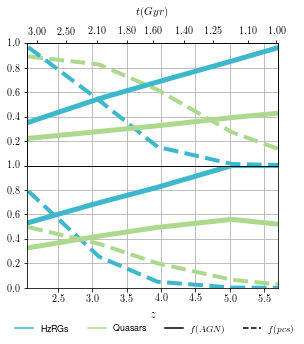

In [541]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(4.5,4.5))

plt.subplots_adjust(hspace=0)

z_lim = 5

ax1.plot(zees[:z_lim], np.array([float(np.sum([x > 0 for x in y])) for y in n_quasar[:z_lim]]) / n_clust[:z_lim], 
        c=cmap[1], lw=4, linestyle='dashed')

ax1.plot(zees[:z_lim], np.array([float(np.sum([x > 0 for x in y])) for y in n_radio[:z_lim]]) / n_clust[:z_lim], 
          c=cmap[4], lw=4, linestyle='dashed')

# cons
ax2.plot(zees[:z_lim], np.array([float(np.sum([x > 0 for x in y])) for y in n_radio_cons[:z_lim]]) / n_clust[:z_lim], 
         c=cmap[4], lw=4, linestyle='dashed')

ax2.plot(zees[:z_lim], np.array([float(np.sum([x > 0 for x in y])) for y in n_quasar_cons[:z_lim]]) / n_clust[:z_lim], 
         c=cmap[1], lw=4, linestyle='dashed')


ax1.plot(zees[:z_lim], np.array(quasar_in_pcs[:z_lim])/np.array(all_quasar[:z_lim]), c=cmap[1], lw=5)
ax1.plot(zees[:z_lim], np.array(radio_in_pcs[:z_lim])/np.array(all_radio[:z_lim]), c=cmap[4], lw=5)

#cons
ax2.plot(zees[:z_lim], np.array(quasar_in_pcs_cons[:z_lim])/np.array(all_quasar_cons[:z_lim]), c=cmap[1], lw=5)
ax2.plot(zees[:z_lim], np.array(radio_in_pcs_cons[:z_lim])/np.array(all_radio_cons[:z_lim]), c=cmap[4], lw=5)


ax2.set_xlabel('$z$', size=13)

for ax in [ax1,ax2]:
    ax.set_ylim(0, 1)
    ax.grid()
    #ax.set_ylabel('$f$', rotation=0, size=20)
    
axt = ax1.twiny()
axt.set_xticks(ageticks)
axt.set_xticklabels(["$%.2f$"%age for age in ages.value]);

axt.set_xlabel('$t (Gyr)$', size=11, labelpad=12)

ax1.set_xticklabels([])
ax1.set_yticklabels(['','$0.2$','$0.4$','$0.6$','$0.8$','$1.0$'])

ax1.set_xlim(2.05, 5.7)
ax2.set_xlim(2.05, 5.7)
axt.set_xlim(2.05, 5.7)

line1 = plt.Line2D((0,1),(0,0), color=cmap[4], linestyle='solid')
line2 = plt.Line2D((0,1),(0,0), color=cmap[1], linestyle='solid')

line3 = plt.Line2D((0,1),(0,0), color='black', linestyle='solid')
line4 = plt.Line2D((0,1),(0,0), color='black', linestyle='dashed')

ax2.legend(handles=[line1, line2, line3, line4], 
           labels=['HzRGs','Quasars',r'$f(AGN)$',r'$f(pcs)$'], 
           loc=(-0.06, -0.4), prop={'size':9}, frameon=False, ncol=4)


# plt.savefig('output/agn_stats.png', bbox_inches='tight', dpi=300)

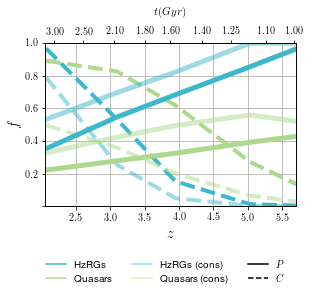

In [567]:
fig, ax1 = plt.subplots(1,1, figsize=(4.5,3))

plt.subplots_adjust(hspace=0)

z_lim = 5

ax1.plot(zees[:z_lim], np.array([float(np.sum([x > 0 for x in y])) for y in n_quasar[:z_lim]]) / n_clust[:z_lim], 
        c=cmap[1], lw=4, linestyle='dashed')

ax1.plot(zees[:z_lim], np.array([float(np.sum([x > 0 for x in y])) for y in n_radio[:z_lim]]) / n_clust[:z_lim], 
          c=cmap[4], lw=4, linestyle='dashed')

# cons
ax1.plot(zees[:z_lim], np.array([float(np.sum([x > 0 for x in y])) for y in n_quasar_cons[:z_lim]]) / n_clust[:z_lim], 
         c=cmap[1], lw=4, linestyle='dashed', alpha=0.5)

ax1.plot(zees[:z_lim], np.array([float(np.sum([x > 0 for x in y])) for y in n_radio_cons[:z_lim]]) / n_clust[:z_lim], 
         c=cmap[4], lw=4, linestyle='dashed', alpha=0.5)


ax1.plot(zees[:z_lim], np.array(quasar_in_pcs[:z_lim])/np.array(all_quasar[:z_lim]), 
         c=cmap[1], lw=5)

ax1.plot(zees[:z_lim], np.array(radio_in_pcs[:z_lim])/np.array(all_radio[:z_lim]), 
         c=cmap[4], lw=5)

#cons
ax1.plot(zees[:z_lim], np.array(quasar_in_pcs_cons[:z_lim])/np.array(all_quasar_cons[:z_lim]), 
         c=cmap[1], lw=5, alpha=0.5)

ax1.plot(zees[:z_lim], np.array(radio_in_pcs_cons[:z_lim])/np.array(all_radio_cons[:z_lim]), 
         c=cmap[4], lw=5, alpha=0.5)


ax1.set_ylim(0, 1)
ax1.grid()
ax1.set_ylabel('$f$', size=15)
ax1.set_xlabel('$z$', size=15)

axt = ax1.twiny()
axt.set_xticks(ageticks)
axt.set_xticklabels(["$%.2f$"%age for age in ages.value]);

axt.set_xlabel('$t (Gyr)$', size=11, labelpad=12)

# ax1.set_xticklabels([])
ax1.set_yticklabels(['','$0.2$','$0.4$','$0.6$','$0.8$','$1.0$'])

ax1.set_xlim(2.05, 5.7)
axt.set_xlim(2.05, 5.7)

line1 = plt.Line2D((0,1),(0,0), color=cmap[4], linestyle='solid')
line2 = plt.Line2D((0,1),(0,0), color=cmap[1], linestyle='solid')

line5 = plt.Line2D((0,1),(0,0), color=cmap[4], alpha=0.5, linestyle='solid')
line6 = plt.Line2D((0,1),(0,0), color=cmap[1], alpha=0.5, linestyle='solid')

line3 = plt.Line2D((0,1),(0,0), color='black', linestyle='solid')
line4 = plt.Line2D((0,1),(0,0), color='black', linestyle='dashed')

ax1.legend(handles=[line1, line2, line5, line6, line3, line4], 
           labels=['HzRGs','Quasars','HzRGs (cons)','Quasars (cons)',r'$P$',r'$C$'], 
           loc=(-0.01, -0.5), prop={'size':10}, frameon=False, ncol=3)


# plt.savefig('output/agn_stats.png', bbox_inches='tight', dpi=300)